In [307]:
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.NTERACT

In [301]:
import pandas as pd
from pyecharts.charts import Bar, Line
from pyecharts import options as opts
from pyecharts.render import make_snapshot
import os

In [302]:
from pyecharts.globals import ThemeType

In [303]:
data_ex1_a = pd.read_csv('D:\\py_project\\HiC_node2vec\\p.txt', sep=' ', header=None)
data_ex1_a

0         1
0    0.064357  0.084659
1    0.075897  0.098696
2    0.229327  0.408286
3    0.229328  0.408286
4    0.231671  0.417375
..        ...       ...
990  0.999980  0.912577
991  0.999986  0.912574
992  0.999991  0.912582
993  1.000000  0.912540
994  1.000000  0.912546

[995 rows x 2 columns]

D:\anaconda\envs\HNX\lib\site-packages\ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  if sys.path[0] == "":
D:\anaconda\envs\HNX\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\HNX\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\HNX\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\HNX\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  f

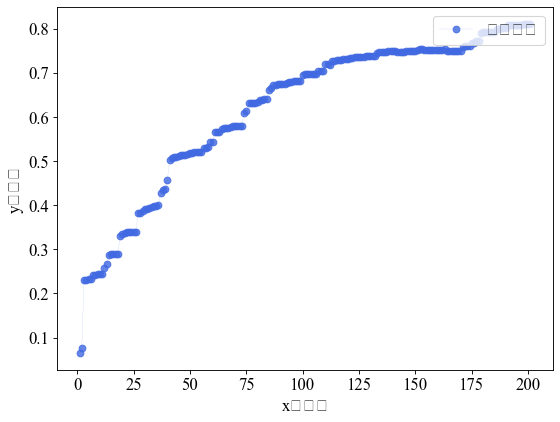

In [320]:
import matplotlib.pyplot as plt
def line():
    plt.figure(figsize=(8, 6), dpi=80)
    plt.rcParams['font.sans-serif'] = ['SimHei']
    labels = ['scSPRITE', 'SpriteHyper2vec']
    colors = [(255/255.,217/255.,102/255.), (137/255.,128/255.,68/255.)]
    data = data_ex1_a
    x = [i for i in range(1, 202)]

    plt.rcParams['font.sans-serif']='SimHei'
    plt.rcParams['axes.unicode_minus']=False
    plt.plot(x, data[0].loc[:200], 'ro-', color='#4169E1', alpha=0.8, linewidth=0.1, label='一些数字')

    # 显示标签，如果不加这句，即使在plot中加了label='一些数字'的参数，最终还是不会显示标签
    plt.legend(loc="upper right")
    plt.xlabel('x轴数字')
    plt.ylabel('y轴数字')

    plt.show()
line()

In [313]:
data = data_ex1_a
x = [i for i in range(1, 202)]
line=(
    Line(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
        .add_xaxis(xaxis_data=x)
        .add_yaxis(series_name="SCC(raw method)",y_axis=data[0].loc[:201].tolist(),is_symbol_show=True,is_smooth=True,
                   label_opts=opts.LabelOpts(is_show=False),)
        .add_yaxis(series_name="SCC(SpriteNode2vec)",y_axis=data[1].loc[:201].tolist(),is_symbol_show=True,is_smooth=True,
                   label_opts=opts.LabelOpts(is_show=False),)
        .set_global_opts(
            title_opts=opts.TitleOpts(title="Verify the SCC correlation"),
            graphic_opts=[
                opts.GraphicGroup(
                    graphic_item=opts.GraphicItem(
                        # 控制整体的位置
                        left="0%",
                        top="50%",
                    ),
                    children=[
                        # opts.GraphicRect控制方框的显示
                        # 如果不需要方框，去掉该段即可

                        # opts.GraphicText控制文字的显示
                        opts.GraphicText(
                            graphic_item=opts.GraphicItem(
                                left="center",
                                top="middle",
                                z=100,
                            ),
                            graphic_textstyle_opts=opts.GraphicTextStyleOpts(
                                # 可以通过jsCode添加js代码，也可以直接用字符串
                                text=(
                                    ""
                                ),
                                font="18px Microsoft YaHei",
                                graphic_basicstyle_opts=opts.GraphicBasicStyleOpts(
                                    fill="#333"
                                )
                            )
                        )
                    ]
                )
            ],
            yaxis_opts = opts.AxisOpts(name = 'SCC correlation'),
            xaxis_opts = opts.AxisOpts(
                type_ = 'category',
                name = 'Cell numbers',

                name_location='center',
                #name_gap = 25,
                #split_number = 4
            )



        )
)

line.render_notebook()


AttributeError: module 'pyecharts.options' has no attribute 'GraphicGroup'

In [305]:
from pyecharts.render import make_snapshot
from snapshot_selenium import snapshot
#make_snapshot(snapshot, line.render(), 'ex1_a.png')

实验1-b

In [198]:
from scipy.sparse import csr_matrix
import warnings
from scipy.stats import pearsonr, PearsonRConstantInputWarning
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
rcParams['axes.unicode_minus'] = False
rcParams['font.sans-serif'] = ['Simhei']

def vstrans(d1, d2):
    """
    Variance stabilizing transformation to normalize read counts before computing
    stratum correlation. This normalizes counts so that different strata share similar
    dynamic ranges.
    Parameters
    ----------
    d1 : numpy.array of floats
        Diagonal of the first matrix.
    d2 : numpy.array of floats
        Diagonal of the second matrix.
    Returns
    -------
    r2k : numpy.array of floats
        Array of weights to use to normalize counts.
    """
    # Get ranks of counts in diagonal
    ranks_1 = np.argsort(d1) + 1
    ranks_2 = np.argsort(d2) + 1
    # Scale ranks betweeen 0 and 1
    nranks_1 = ranks_1 / max(ranks_1)
    nranks_2 = ranks_2 / max(ranks_2)
    nk = len(ranks_1)
    r2k = np.sqrt(np.var(nranks_1 / nk) * np.var(nranks_2 / nk))
    return r2k


def load_q(a):
    b = []
    with open(a, 'r', encoding='utf-8') as f:
        while True:
            line = f.readline()
            if not line:
                break;
            a = line.strip().split()
            '''if(a[0] >= a[1]):
                break'''
            b.append(a)
    return b


def main():
    b1 = load_q('D:\\py_project\\HiC_node2vec\\p_5.txt')
    b2 = load_q('D:\\py_project\\HiC_node2vec\\p_10.txt')
    b3 = load_q('D:\\py_project\\HiC_node2vec\\p_20.txt')
    b4 = load_q('D:\\py_project\\HiC_node2vec\\p_50.txt')
    plt.figure(figsize=(10, 8), dpi=80)
    raw = np.zeros((4, 20))
    node2vec = np.zeros((4, 20))
    a = []
    b = []
    for i in range(len(b1)):
        a.append(round(float(b1[i][0]), 2))
        b.append(round(float(b1[i][1]), 2))
    raw[0, : len(b1)] = a
    node2vec[0, : len(b1)] = b
    a = []
    b = []
    for i in range(len(b2)):
        a.append(round(float(b2[i][0]), 2))
        b.append(round(float(b2[i][1]), 2))
    raw[1, : len(b2)] = a
    node2vec[1, : len(b2)] = b
    a = []
    b = []
    for i in range(len(b3)):
        a.append(round(float(b3[i][0]), 2))
        b.append(round(float(b3[i][1]), 2))
    raw[2, : len(b3)] = a
    node2vec[2, : len(b3)] = b
    a = []
    b = []
    for i in range(len(b4)):
        a.append(round(float(b4[i][0]), 2))
        b.append(round(float(b4[i][1]), 2))
    raw[3, : len(b4)] = a
    node2vec[3, : len(b4)] = b
    plt.rc('font', family='Times New Roman', size=15)
    plt.boxplot(raw[0], labels=['5'], showmeans=True, positions=[0.1])
    plt.boxplot(node2vec[0], labels=['5'], showmeans=True, positions=[0.25])
    plt.boxplot(raw[1], labels=['10'], showmeans=True, positions=[1.1])
    plt.boxplot(node2vec[1], labels=['10'], showmeans=True, positions=[1.25])
    plt.boxplot(raw[2], labels=['20'], showmeans=True, positions=[2.1])
    plt.boxplot(node2vec[2], labels=['20'], showmeans=True, positions=[2.25])
    plt.boxplot(raw[3], labels=['50'], showmeans=True, positions=[3.1])
    plt.boxplot(node2vec[3], labels=['50'], showmeans=True, positions=[3.25])
    #plt.legend(loc='best')
    #plt.xticks(range(0, len(b), 5))
    #plt.grid(True, linestyle='--', alpha=0.5)
    plt.tick_params(labelsize=10)
    plt.xlabel("cells", fontdict={'size': 10})
    plt.ylabel("scc", fontdict={'size': 10})
    plt.title("raw vs node2vec under different cell population(100kb)", fontdict={'size': 12})
    plt.show()
    plt.close()

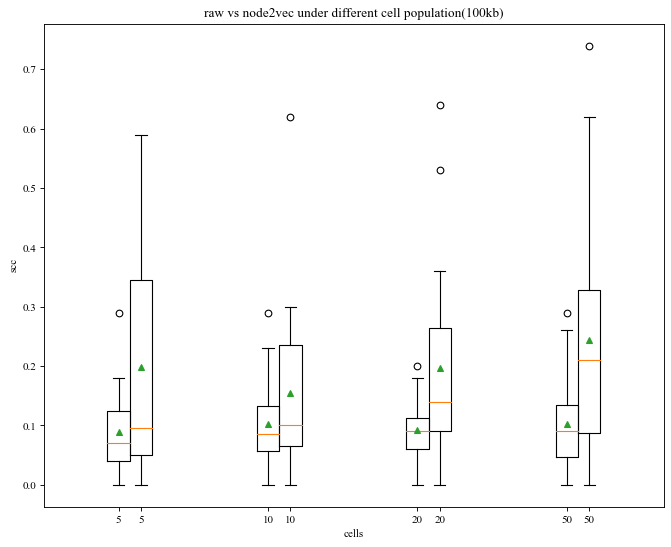

In [199]:
main()

实验1-b 补充

In [268]:
from scipy.stats import pearsonr, zscore
import scipy
from tqdm import tqdm
def pearson_score(m1, m2):
    return pearsonr(m1.reshape((-1)), m2.reshape((-1)))[0]
def zscore_norm(matrix):
    v = matrix.reshape((-1))
    if not (v == v[0]).all():
        matrix = zscore(v).reshape((len(matrix), -1))
    return matrix

def Result_record(file_dir, chr_key, file, re):
    chr_dir = file_dir + '/' + file + '/' + chr_key + '/' + file + '_' + chr_key  + '_' + str(re) + '.npz'
    if os.path.isfile(chr_dir):
        return True
    return False
def Result_record2(file_dir, chr_key, file, re):
    chr_dir = file_dir + '/' + file + '/' + chr_key + '/' + file + '_' + chr_key + '.npz'
    if os.path.isfile(chr_dir):
        return True
    return False

def get_rawandout(file, file_dir, chr_key, re, type):
    #100kb
    o_dir = file_dir + '/' + file + '/' + chr_key + '/' + file + '_' + chr_key + '_' + str(re) + type
    r_dir = file_dir + '/' + file + '/' + chr_key + '/' + 'raw_' + chr_key + '_' + str(re) + type
    #print(o_dir)
    if type == '.matrix.gz' or type == '.txt':
        raw = np.loadtxt(r_dir)
        node = np.loadtxt(o_dir)
        return raw, node
    elif type == '.npz':
        raw = scipy.sparse.load_npz(r_dir)
        node = scipy.sparse.load_npz(o_dir)
        return raw, node
    return #print('error : get none mat')

def get_rawandout2(file, file_dir, chr_key, re, type):
    #100kb
    o_dir = file_dir + '/' + file + '/' + chr_key + '/' + file + '_' + chr_key + type
    r_dir = file_dir + '/' + file + '/' + chr_key + '/' + 'raw_' + chr_key + type
    #print(o_dir)
    if type == '.matrix.gz' or type == '.txt':
        raw = np.loadtxt(r_dir)
        node = np.loadtxt(o_dir)
        return raw, node
    elif type == '.npz':
        raw = scipy.sparse.load_npz(r_dir)
        node = scipy.sparse.load_npz(o_dir)
        return raw, node
    return #print('error : get none mat')

def get_mat2(file_dir, files, chr, re, type):
    '''
    :param chr:
    :param num:
    :param re:
    :param type:.npz'
    :param output_dir:
    :return:
    '''
    HiC_dir = file_dir + '/lym/HiC_node2vec'
    chr_key = chr
    if Result_record(HiC_dir, chr_key, files[0], re):
        raw, node = get_rawandout(files[0], HiC_dir, chr_key, re, type)
        raw = raw.todense()
        node = node.todense()
        return raw, node
    '''if len(files) > 1 :
        for file in tqdm(files[1:]):
            if Result_record(HiC_dir, chr_key, file):
                r, n = get_rawandout(file, HiC_dir, chr_key, re, type)
        if node.shape == n.shape:
            raw = raw + r
            node = node + n
    if type == '.npz':
        raw = raw.todense()
        node = node.todense()'''

def get_mat3(file_dir, files, chr, re, type):
    '''
    :param chr:
    :param num:
    :param re:
    :param type:.npz'
    :param output_dir:
    :return:
    '''
    HiC_dir = file_dir + '/HiC_node2vec'
    chr_key = chr
    raw, node = get_rawandout(files[0], HiC_dir, chr_key, re, type)
    if len(files) > 1 :
        for file in tqdm(files[1:]):

            r, n = get_rawandout(file, HiC_dir, chr_key, re, type)
            if node.shape == n.shape:
                raw = raw + r
                node = node + n
    if type == '.npz':
        raw = raw.todense()
        node = node.todense()
    return raw, node

def get_file_name(file_dir):
    L = []
    for root, dirs, files in os.walk(file_dir):
        for file in files:
            L.append(file)
    return L


def randomfile(file_dir, r):
    scSCRIPE_dir = file_dir + '\\filtered_1000_cells_single_cell_files'
    files = get_file_name(scSCRIPE_dir)
    np.random.shuffle(files)
    return files[:r]

In [272]:
from higashi import get_scc2
def get_scc(files, a):
    r, n = get_mat3('D:\\dataset', files, 'chr4', 10000, '.npz')
    a1, b1 = get_scc2(a, r, 1000)
    a2, b2 = get_scc2(a, n, 1000)

    return a1, a2

In [258]:
col = ['round', 'num', 'raw', 'node']
p = pd.DataFrame(columns=col)
all = np.loadtxt('D:\\py_project\\HiC_node2vec\\sprite\\raw_all_100000.matrix')

In [ ]:
l_cell = pd.read_csv('D:\\py_project\\HiC_node2vec\\sprite\\l_cell.csv', index_col=0)
l_cell = l_cell['0'].tolist()
files = randomfile('D:\\dataset', 1000)
HiC_dir = 'D:\\dataset' + '\\lym\\HiC_node2vec'
while l_cell:
    for file in l_cell:
        files.remove(file)
        l_cell.remove(file)
for file in files:
    if not Result_record2(HiC_dir, 'chr1', file, 10000):
        files.remove(file)
index = 0
for i in [5, 10, 50, 100]:
    for j in range(20):
        np.random.shuffle(files)
        f_1 = files[:i]
        a_raw, a_node = get_scc(f_1, all)
        p.loc[index] = [j, i ,a_raw, a_node]
        index += 1
    index += 1


In [277]:
stat,p_value = scipy.stats.ttest_ind(p.loc[p['num']==5, 'raw'].tolist(),
                                     p.loc[p['num']==5, 'node'].tolist(),
                                     equal_var=False)
print(p_value)

0.002425551173403858


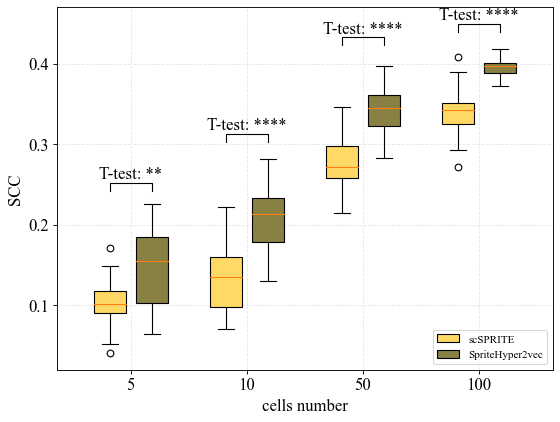

In [296]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"
def box():
    plt.figure(figsize=(8, 6), dpi=80)
    plt.rcParams['font.sans-serif'] = ['SimHei']
    labels = ['scSPRITE', 'SpriteHyper2vec']
    colors = [(255/255.,217/255.,102/255.), (137/255.,128/255.,68/255.)]
    bplot = plt.boxplot([p.loc[p['num']==5, 'raw'].tolist(), p.loc[p['num']==5, 'node'].tolist()], patch_artist=True,labels=labels,positions=(1,1.4),widths=0.3)
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    # 添加P值
    x1, x2 = 1,1.4
    y,h = p.loc[p['num']==5, 'raw'].mean()+0.14,.01
    #绘制横线位置
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    #添加P值
    stat,p_value = scipy.stats.ttest_ind(p.loc[p['num']==5, 'raw'].tolist(),
                                         p.loc[p['num']==5, 'node'].tolist(),
                                         equal_var=False)
    plt.text((x1+x2)*.5, y+h, "T-test: "+ convert_pvalue_to_asterisks(p_value), ha='center', va='bottom', color="k")

    bplot2 = plt.boxplot([p.loc[p['num']==10, 'raw'].tolist(), p.loc[p['num']==10, 'node'].tolist()], patch_artist=True, labels=labels,positions=(2.1,2.5),widths=0.3)
    for patch, color in zip(bplot2['boxes'], colors):
        patch.set_facecolor(color)
    x1, x2 = 2.1,2.5
    y,h = p.loc[p['num']==10, 'raw'].mean()+0.17,.01
    #绘制横线位置
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    #添加P值
    stat,p_value = scipy.stats.ttest_ind(p.loc[p['num']==10, 'raw'].tolist(),
                                         p.loc[p['num']==10, 'node'].tolist(),
                                         equal_var=False)
    plt.text((x1+x2)*.5, y+h, "T-test: "+ convert_pvalue_to_asterisks(p_value), ha='center', va='bottom', color="k")



    bplot3 = plt.boxplot([p.loc[p['num']==50, 'raw'].tolist(), p.loc[p['num']==50, 'node'].tolist()], patch_artist=True, labels=labels,positions=(3.2, 3.6),widths=0.3)
    for patch, color in zip(bplot3['boxes'], colors):
        patch.set_facecolor(color)
    x1, x2 = 3.2, 3.6
    y,h = p.loc[p['num']==50, 'raw'].mean()+0.15,.01
    #绘制横线位置
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    #添加P值
    stat,p_value = scipy.stats.ttest_ind(p.loc[p['num']==50, 'raw'].tolist(),
                                         p.loc[p['num']==50, 'node'].tolist(),
                                         equal_var=False)
    plt.text((x1+x2)*.5, y+h, "T-test: "+ convert_pvalue_to_asterisks(p_value), ha='center', va='bottom', color="k")

    bplot4 = plt.boxplot([p.loc[p['num']==100, 'raw'].tolist(), p.loc[p['num']==100, 'node'].tolist()], patch_artist=True, labels=labels,positions=(4.3, 4.7),widths=0.3)
    for patch, color in zip(bplot4['boxes'], colors):
        patch.set_facecolor(color)
    x1, x2 = 4.3, 4.7
    y,h = p.loc[p['num']==100, 'raw'].mean()+0.1,.01
    #绘制横线位置
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    #添加P值
    stat,p_value = scipy.stats.ttest_ind(p.loc[p['num']==100, 'raw'].tolist(),
                                         p.loc[p['num']==100, 'node'].tolist(),
                                         equal_var=False)
    plt.text((x1+x2)*.5, y+h, "T-test: "+ convert_pvalue_to_asterisks(p_value), ha='center', va='bottom', color="k")

    x_position=[1,2.1,3.2, 4.3]
    x_position_fmt=["5","10","50", '100']
    plt.xticks([i + 0.4 / 2 for i in x_position], x_position_fmt)
    plt.ylabel('SCC')
    plt.xlabel('cells number')
    plt.grid(linestyle="--", alpha=0.3)  #绘制图中虚线 透明度0.3
    plt.legend(bplot['boxes'],labels,loc='lower right', prop={'size':10})  #绘制表示框，右下角绘制
    #plt.savefig(fname="pic.png",figsize=[10,10])
    plt.show()
box()

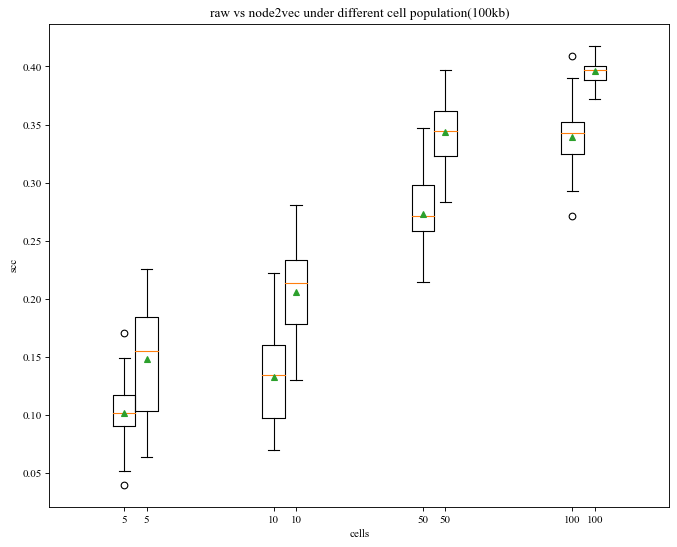

In [270]:
plt.figure(figsize=(10, 8), dpi=80)
plt.rc('font', family='Times New Roman', size=15)
plt.boxplot(p.loc[p['num']==5, 'raw'].tolist(), labels=['5'], showmeans=True, positions=[0.1])
plt.boxplot(p.loc[p['num']==5, 'node'].tolist(), labels=['5'], showmeans=True, positions=[0.25])
plt.boxplot(p.loc[p['num']==10, 'raw'].tolist(), labels=['10'], showmeans=True, positions=[1.1])
plt.boxplot(p.loc[p['num']==10, 'node'].tolist(), labels=['10'], showmeans=True, positions=[1.25])
plt.boxplot(p.loc[p['num']==50, 'raw'].tolist(), labels=['50'], showmeans=True, positions=[2.1])
plt.boxplot(p.loc[p['num']==50, 'node'].tolist(), labels=['50'], showmeans=True, positions=[2.25])
plt.boxplot(p.loc[p['num']==100, 'raw'].tolist(), labels=['100'], showmeans=True, positions=[3.1])
plt.boxplot(p.loc[p['num']==100, 'node'].tolist(), labels=['100'], showmeans=True, positions=[3.25])
#plt.legend(loc='best')
#plt.xticks(range(0, len(b), 5))
#plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(labelsize=10)
plt.xlabel("cells", fontdict={'size': 10})
plt.ylabel("scc", fontdict={'size': 10})
plt.title("raw vs node2vec under different cell population(100kb)", fontdict={'size': 12})
plt.show()
plt.close()

实验1-c

In [ ]:
q = pd.DataFrame(columns=col)

In [275]:
from scipy import sparse
#q = pd.DataFrame(columns=col)
f2 = randomfile('D:\\dataset', 1000)
l_cell = pd.read_csv('D:\\py_project\\HiC_node2vec\\sprite\\l_cell.csv', index_col=0)
l_cell = l_cell['0'].tolist()
files = randomfile('D:\\dataset', 1000)
HiC_dir = 'D:\\dataset' + '\\lym\\HiC_node2vec'
while l_cell:
    for file in l_cell:
        files.remove(file)
        l_cell.remove(file)
for file in files:
    if not Result_record(HiC_dir, 'chr4', file, 10000):
        files.remove(file)
all = sparse.load_npz('D:\\py_project\\HiC_node2vec\\raw_all_10000.npz')
all = all.todense()
index = 0
for i in [5, 10, 50, 100]:
    for j in range(18):
        np.random.shuffle(files)
        f_1 = files[:i]
        a_raw, a_node = get_scc(f_1, all)
        q.loc[index] = [j, i ,a_raw, a_node]
        index += 1
    index += 1

100%|██████████| 99/99 [00:22<00:00,  4.38it/s]


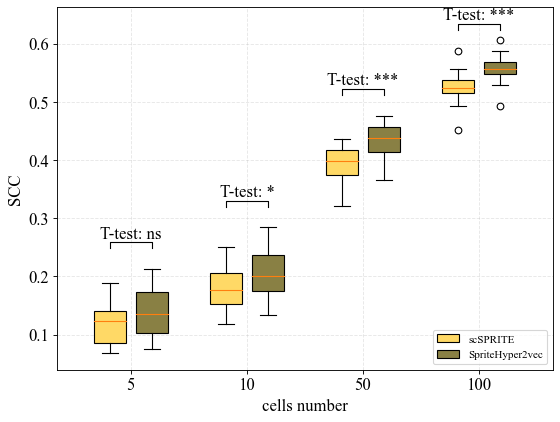

In [299]:
def box(p):
    plt.figure(figsize=(8, 6), dpi=80)
    plt.rcParams['font.sans-serif'] = ['SimHei']
    labels = ['scSPRITE', 'SpriteHyper2vec']
    colors = [(255/255.,217/255.,102/255.), (137/255.,128/255.,68/255.)]
    bplot = plt.boxplot([p.loc[p['num']==5, 'raw'].tolist(), p.loc[p['num']==5, 'node'].tolist()], patch_artist=True,labels=labels,positions=(1,1.4),widths=0.3)
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    # 添加P值
    x1, x2 = 1,1.4
    y,h = p.loc[p['num']==5, 'raw'].mean()+0.13,.01
    #绘制横线位置
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    #添加P值
    stat,p_value = scipy.stats.ttest_ind(p.loc[p['num']==5, 'raw'].tolist(),
                                         p.loc[p['num']==5, 'node'].tolist(),
                                         equal_var=False)
    plt.text((x1+x2)*.5, y+h, "T-test: "+ convert_pvalue_to_asterisks(p_value), ha='center', va='bottom', color="k")

    bplot2 = plt.boxplot([p.loc[p['num']==10, 'raw'].tolist(), p.loc[p['num']==10, 'node'].tolist()], patch_artist=True, labels=labels,positions=(2.1,2.5),widths=0.3)
    for patch, color in zip(bplot2['boxes'], colors):
        patch.set_facecolor(color)
    x1, x2 = 2.1,2.5
    y,h = p.loc[p['num']==10, 'raw'].mean()+0.14,.01
    #绘制横线位置
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    #添加P值
    stat,p_value = scipy.stats.ttest_ind(p.loc[p['num']==10, 'raw'].tolist(),
                                         p.loc[p['num']==10, 'node'].tolist(),
                                         equal_var=False)
    plt.text((x1+x2)*.5, y+h, "T-test: "+ convert_pvalue_to_asterisks(p_value), ha='center', va='bottom', color="k")



    bplot3 = plt.boxplot([p.loc[p['num']==50, 'raw'].tolist(), p.loc[p['num']==50, 'node'].tolist()], patch_artist=True, labels=labels,positions=(3.2, 3.6),widths=0.3)
    for patch, color in zip(bplot3['boxes'], colors):
        patch.set_facecolor(color)
    x1, x2 = 3.2, 3.6
    y,h = p.loc[p['num']==50, 'raw'].mean()+0.12,.01
    #绘制横线位置
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    #添加P值
    stat,p_value = scipy.stats.ttest_ind(p.loc[p['num']==50, 'raw'].tolist(),
                                         p.loc[p['num']==50, 'node'].tolist(),
                                         equal_var=False)
    plt.text((x1+x2)*.5, y+h, "T-test: "+ convert_pvalue_to_asterisks(p_value), ha='center', va='bottom', color="k")

    bplot4 = plt.boxplot([p.loc[p['num']==100, 'raw'].tolist(), p.loc[p['num']==100, 'node'].tolist()], patch_artist=True, labels=labels,positions=(4.3, 4.7),widths=0.3)
    for patch, color in zip(bplot4['boxes'], colors):
        patch.set_facecolor(color)
    x1, x2 = 4.3, 4.7
    y,h = p.loc[p['num']==100, 'raw'].mean()+0.1,.01
    #绘制横线位置
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    #添加P值
    stat,p_value = scipy.stats.ttest_ind(p.loc[p['num']==100, 'raw'].tolist(),
                                         p.loc[p['num']==100, 'node'].tolist(),
                                         equal_var=False)
    plt.text((x1+x2)*.5, y+h, "T-test: "+ convert_pvalue_to_asterisks(p_value), ha='center', va='bottom', color="k")

    x_position=[1,2.1,3.2, 4.3]
    x_position_fmt=["5","10","50", '100']
    plt.xticks([i + 0.4 / 2 for i in x_position], x_position_fmt)
    plt.ylabel('SCC')
    plt.xlabel('cells number')
    plt.grid(linestyle="--", alpha=0.3)  #绘制图中虚线 透明度0.3
    plt.legend(bplot['boxes'],labels,loc='lower right', prop={'size':10})  #绘制表示框，右下角绘制
    #plt.savefig(fname="pic.png",figsize=[10,10])
    plt.show()
box(q)

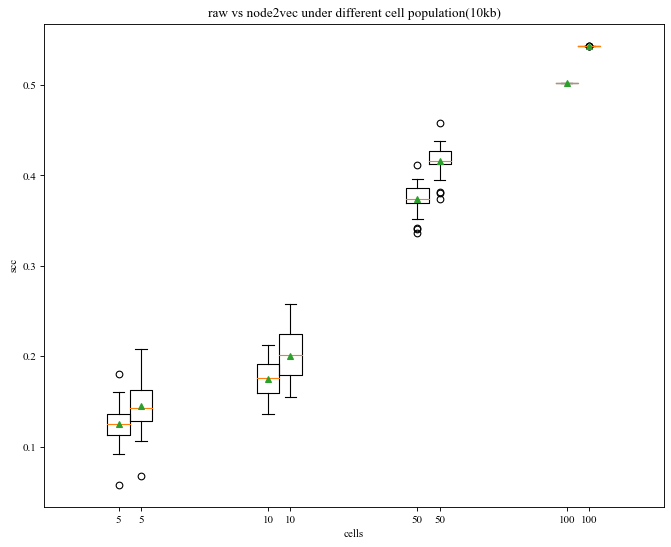

In [86]:
plt.figure(figsize=(10, 8), dpi=80)
plt.rc('font', family='Times New Roman', size=15)
plt.boxplot(p.loc[p['num']==5, 'raw'].tolist(), labels=['5'], showmeans=True, positions=[0.1])
plt.boxplot(p.loc[p['num']==5, 'node'].tolist(), labels=['5'], showmeans=True, positions=[0.25])
plt.boxplot(p.loc[p['num']==10, 'raw'].tolist(), labels=['10'], showmeans=True, positions=[1.1])
plt.boxplot(p.loc[p['num']==10, 'node'].tolist(), labels=['10'], showmeans=True, positions=[1.25])
plt.boxplot(p.loc[p['num']==50, 'raw'].tolist(), labels=['50'], showmeans=True, positions=[2.1])
plt.boxplot(p.loc[p['num']==50, 'node'].tolist(), labels=['50'], showmeans=True, positions=[2.25])
plt.boxplot(p.loc[p['num']==100, 'raw'].tolist(), labels=['100'], showmeans=True, positions=[3.1])
plt.boxplot(p.loc[p['num']==100, 'node'].tolist(), labels=['100'], showmeans=True, positions=[3.25])
#plt.legend(loc='best')
#plt.xticks(range(0, len(b), 5))
#plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(labelsize=10)
plt.xlabel("cells", fontdict={'size': 10})
plt.ylabel("scc", fontdict={'size': 10})
plt.title("raw vs node2vec under different cell population(10kb)", fontdict={'size': 12})
plt.show()
plt.close()

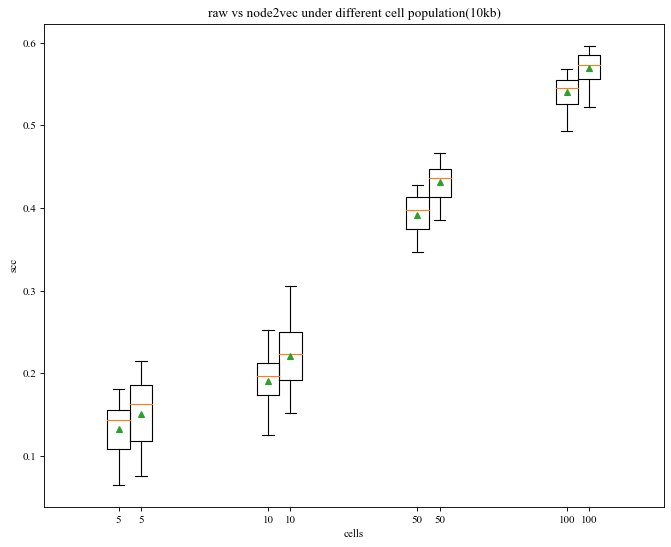

In [90]:
plt.figure(figsize=(10, 8), dpi=80)
plt.rc('font', family='Times New Roman', size=15)
plt.boxplot(q.loc[p['num']==5, 'raw'].tolist(), labels=['5'], showmeans=True, positions=[0.1])
plt.boxplot(q.loc[p['num']==5, 'node'].tolist(), labels=['5'], showmeans=True, positions=[0.25])
plt.boxplot(q.loc[p['num']==10, 'raw'].tolist(), labels=['10'], showmeans=True, positions=[1.1])
plt.boxplot(q.loc[p['num']==10, 'node'].tolist(), labels=['10'], showmeans=True, positions=[1.25])
plt.boxplot(q.loc[p['num']==50, 'raw'].tolist(), labels=['50'], showmeans=True, positions=[2.1])
plt.boxplot(q.loc[p['num']==50, 'node'].tolist(), labels=['50'], showmeans=True, positions=[2.25])
plt.boxplot(q.loc[p['num']==100, 'raw'].tolist(), labels=['100'], showmeans=True, positions=[3.1])
plt.boxplot(q.loc[p['num']==100, 'node'].tolist(), labels=['100'], showmeans=True, positions=[3.25])
#plt.legend(loc='best')
#plt.xticks(range(0, len(b), 5))
#plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(labelsize=10)
plt.xlabel("cells", fontdict={'size': 10})
plt.ylabel("scc", fontdict={'size': 10})
plt.title("raw vs node2vec under different cell population(10kb)", fontdict={'size': 12})
plt.show()
plt.close()

In [ ]:
files = randomfile('D:\\dataset', 1000)
l_cell = pd.read_csv('D:\\py_project\\HiC_node2vec\\sprite\\l_cell.csv', index_col=0)
l_cell = l_cell['0'].tolist()
HiC_dir = 'D:\\dataset' + '\\lym\\HiC_node2vec'
while l_cell:
    for file in l_cell:
        files.remove(file)
        l_cell.remove(file)
all_40000 = np.loadtxt('D:\\py_project\\HiC_node2vec\\notebooks\\dsProject\\raw_all_chr4_40000.matrix.gz')
all_100000 = np.loadtxt('D:\\py_project\\HiC_node2vec\\notebooks\\dsProject\\raw_all_chr4_100000.matrix.gz')
all = sparse.load_npz('D:\\py_project\\HiC_node2vec\\raw_all_10000.npz')
all = all.todense()

In [ ]:
files = files[:100]


In [8]:
import matplotlib.gridspec as gridspec
from higashi import zscore_norm
def fig_chr_heatmap(mat1, mat2, mat3):
    fig = plt.figure(figsize=(20, 6))
    widths = [5, 5, 8]
    heights = [5]
    #gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=widths,height_ratios=heights)
    #data = np.tril(out_matrix, k=0) + np.triu(raw_out_matrix, k=0)
    ax = plt.subplot(1, 3,1)
    ax.matshow(mat1, cmap='YlOrRd', vmin=-1, vmax=1.5)
    ax.set_title('100-kb resolution', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax.set_xticks([])
    ax.set_xlabel('zscore-normalized contacts')
    ax = plt.subplot(1, 3, 2)
    ax.matshow(mat2, cmap='YlOrRd', vmin=-1, vmax=1.5)
    ax.set_title('40-kb resolution', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax.set_xticks([])
    ax.set_xlabel('zscore-normalized contacts')
    ax = plt.subplot(1, 3, 3)
    c = ax.matshow(mat3, cmap='YlOrRd', vmin=-1, vmax=1.5)
    ax.set_title('10-kb resolution', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax.set_xticks([])
    ax.set_xlabel('zscore-normalized contacts')
    fig.subplots_adjust(right=0.9)
    fig.text(0.1, 0.5, 'bin', va='center', rotation='vertical')
    fig.text(0.08, 0.1, 'scSpriteNode2vec', size= 'medium')
    fig.text(0.3, 0.9, 'Ensemble data', size= 'medium')
    #colorbar 左 下 宽 高
    l = 0.91
    b = 0.12
    w = 0.015
    h = 1 - 2*b

    #对应 l,b,w,h；设置colorbar位置；
    rect = [l,b,w,h]
    cbar_ax = fig.add_axes(rect)
    cb = plt.colorbar(c, cax=cbar_ax)

    #设置colorbar标签字体等
    cb.ax.tick_params(labelsize=16)  #设置色标刻度字体大小。
    font = {'family' : 'serif',
            #       'color'  : 'darkred',
            'color'  : 'black',
            'weight' : 'normal',
            'size'   : 16,
            }
    cb.set_label('T' ,fontdict=font) #设置colorbar的标签字体及其大小
    plt.show()
def get_scc(files, a):
    r_10000, n_10000 = get_mat3('D:\\dataset', files, 'chr4', 10000, '.npz')
    r_40000, n_40000 = get_mat3('D:\\dataset', files, 'chr4', 40000, '.npz')
    r_100000, n_100000 = get_mat3('D:\\dataset', files, 'chr4', 100000, '.npz')
    '''a1, b1 = get_scc2(a, r_10000, 1000)
    a2, b2 = get_scc2(a, n_10000, 1000)
    a1_40, b1_40 = get_scc2(all_40000, r_40000, 1000)
    a2_40, b2_40 = get_scc2(all_40000, n_40000, 1000)
    a1_100, b1_100 = get_scc2(all_100000, r_100000, 1000)
    a2_100, b2_100 = get_scc2(all_100000, n_100000, 1000)'''
    mat3 = np.tril(zscore_norm(np.array(n_10000)), k=0) + np.triu(zscore_norm(np.array(a)), k=0)
    mat2 = np.tril(zscore_norm(np.array(n_40000)), k=0) + np.triu(zscore_norm(np.array(all_40000)), k=0)
    mat1 = np.tril(zscore_norm(np.array(n_100000)), k=0) + np.triu(zscore_norm(np.array(all_100000)), k=0)
    fig_chr_heatmap(mat1, mat2, mat3)
    return


(0.5028448286059848,
 0.5437539830686334,
 0.7009064831424325,
 0.7643613093228371,
 0.8234844228846134,
 0.8596448314701082)

In [ ]:
get_scc(files, all)

In [50]:
def Result_record2(file_dir, chr_key, file, re):
    chr_dir = file_dir + '/' + file + '/' + chr_key + '/' + file + '_' + chr_key + '.npz'
    if os.path.isfile(chr_dir):
        return True

    return False

def get_scc_chr1(files, a):
    r_20000, n_20000 = get_mat3('D:\\dataset', files, 'chr1', 20000, '.npz')
    r_40000, n_40000 = get_mat3('D:\\dataset', files, 'chr1', 40000, '.npz')
    r_100000, n_100000 = get_mat4('D:\\dataset', files, 'chr1', 100000, '.npz')
    a1, b1 = get_scc2(all_chr1_20000, r_20000, 1000)
    a2, b2 = get_scc2(all_chr1_20000, n_20000, 1000)
    a1_40, b1_40 = get_scc2(all_chr1_40000, r_40000, 1000)
    a2_40, b2_40 = get_scc2(all_chr1_40000, n_40000, 1000)
    a1_100, b1_100 = get_scc2(all_chr1_100000, r_100000, 1000)
    a2_100, b2_100 = get_scc2(all_chr1_100000, n_100000, 1000)
    mat3 = np.tril(zscore_norm(np.array(n_20000)), k=0) + np.triu(zscore_norm(np.array(all_chr1_20000)), k=0)
    mat2 = np.tril(zscore_norm(np.array(n_40000)), k=0) + np.triu(zscore_norm(np.array(all_chr1_40000)), k=0)
    mat1 = np.tril(zscore_norm(np.array(n_100000)), k=0) + np.triu(zscore_norm(np.array(all_chr1_100000)), k=0)
    fig_chr_heatmap(mat1, mat2, mat3)
    return a1, a2, a1_40, a2_40, a1_100, a2_100
def get_mat4(file_dir, files, chr, re, type):
    '''
    :param chr:
    :param num:
    :param re:
    :param type:.npz'
    :param output_dir:
    :return:
    '''
    HiC_dir = file_dir + '/lym/HiC_node2vec'
    chr_key = chr
    raw, node = get_rawandout2(files[0], HiC_dir, chr_key, re, type)
    if len(files) > 1 :
        for file in tqdm(files[1:]):

            r, n = get_rawandout2(file, HiC_dir, chr_key, re, type)
            if node.shape == n.shape:
                raw = raw + r
                node = node + n
    if type == '.npz':
        raw = raw.todense()
        node = node.todense()
    return raw, node


In [9]:
files = randomfile('D:\\dataset', 1000)
all_chr1_20000 = get_mat3('D:\\dataset', files, 'chr1', 20000, '.npz')
all_chr1_40000 = get_mat3('D:\\dataset', files, 'chr1', 40000, '.npz')
all_chr1_100000 = np.loadtxt('raw_all_chr1_100000.matrix.gz')

100%|██████████| 999/999 [05:12<00:00,  3.20it/s]


100%|██████████| 99/99 [00:05<00:00, 16.81it/s]


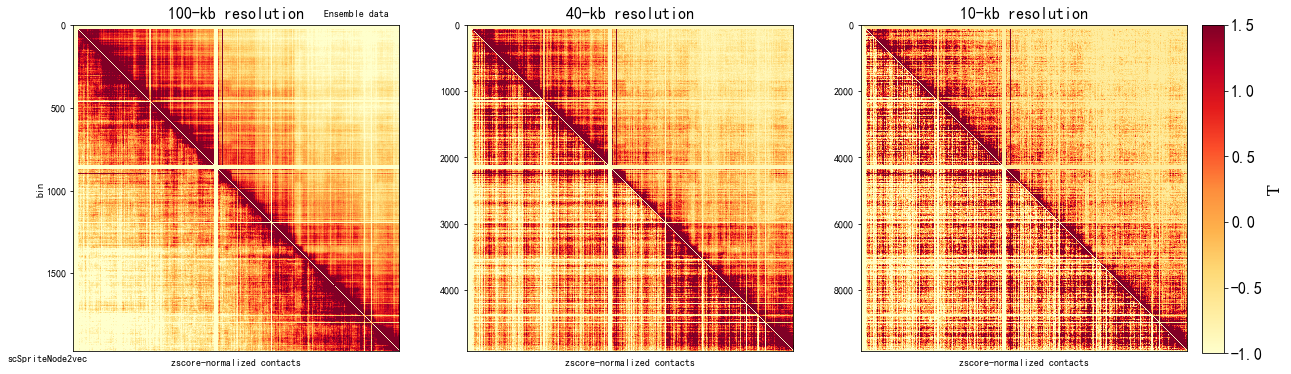

In [37]:
file_chr1 = []
for file in files:
    if Result_record2('D:\\dataset\\lym\\HiC_node2vec', 'chr1', file, 100000):
        file_chr1.append(file)
get_scc_chr1(file_chr1[:100], all_chr1_100000)

100%|██████████| 99/99 [00:05<00:00, 16.51it/s]


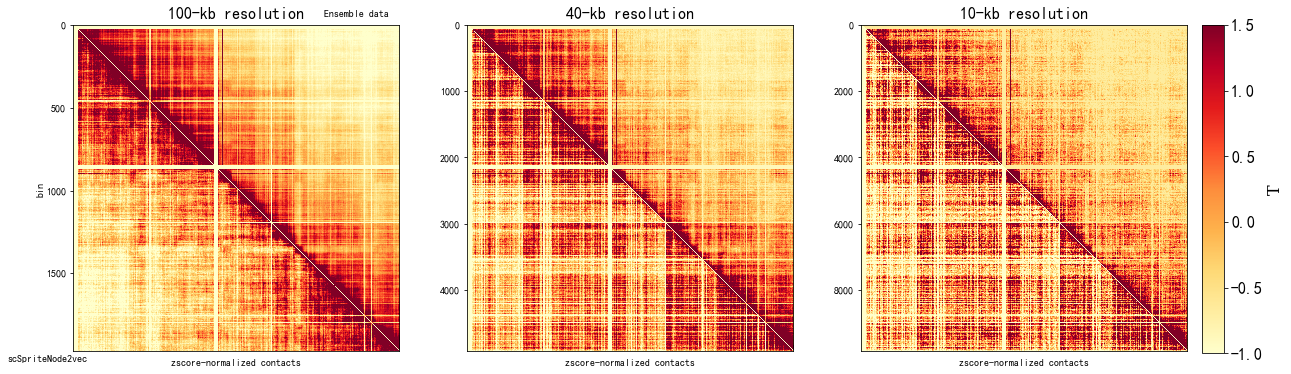

(0.570773880708721, 0.672083914147594, 0.6348665195628314, 0.7509090510189378, 0.7563673025909627, 0.8123730278633079)


In [43]:
l_cell = pd.read_csv('D:\\py_project\\HiC_node2vec\\sprite\\l_cell.csv', index_col=0)
l_cell = l_cell['0'].tolist()
file_chr1 = []
for file in files:
    if Result_record2('D:\\dataset\\lym\\HiC_node2vec', 'chr1', file, 100000) and file not in l_cell:
        file_chr1.append(file)
np.random.shuffle(file_chr1)
print(get_scc_chr1(file_chr1[:100], all_chr1_100000))

(0.570773880708721, 0.672083914147594, 0.6348665195628314, 0.7509090510189378, 0.7563673025909627, 0.8123730278633079)

In [151]:
files = randomfile("D:\\dataset", 1000)
l_cell = pd.read_csv('D:\\py_project\\HiC_node2vec\\sprite\\l_cell.csv', index_col=0)
l_cell = l_cell['0'].tolist()
file_chr2 = []
for file in files:
    if Result_record3('D:\\dataset\\lym\\HiC_node2vec', 'chr2', file, 100000) and file not in l_cell:
        file_chr2.append(file)
r, n = get_mat4('D:\\dataset', file_chr2[:100], 'chr2', 100000, '.txt')

100%|██████████| 99/99 [04:15<00:00,  2.58s/it]


In [189]:
from higashi import compartment
from scipy.interpolate import make_interp_spline
def heatmap_cp(mat):
    fig = plt.figure(figsize=(20, 6))
    ax = plt.subplot(1, 3, 1)
    c = ax.matshow(mat, cmap='YlOrRd', vmin=-1, vmax=1.5)
    ax.set_title('100-kb resolution', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax.set_xticks([])
    ax.set_xlabel('zscore-normalized contacts')
    fig.subplots_adjust(right=0.9)
    fig.text(0.1, 0.5, 'bin', va='center', rotation='vertical')
    fig.text(0.08, 0.1, 'scSpriteNode2vec', size= 'medium')
    fig.text(0.3, 0.9, 'Ensemble data', size= 'medium')
    #colorbar 左 下 宽 高
    l = 0.91
    b = 0.12
    w = 0.015
    h = 1 - 2*b
    #对应 l,b,w,h；设置colorbar位置；
    rect = [l,b,w,h]
    cbar_ax = fig.add_axes(rect)
    cb = plt.colorbar(c, cax=cbar_ax)
    #设置colorbar标签字体等
    cb.ax.tick_params(labelsize=16)  #设置色标刻度字体大小。
    font = {'family' : 'serif',
            #       'color'  : 'darkred',
            'color'  : 'black',
            'weight' : 'normal',
            'size'   : 16,
            }
    cb.set_label('T' ,fontdict=font) #设置colorbar的标签字体及其大小
    plt.show()
def Result_record3(file_dir, chr_key, file, re):
    chr_dir = file_dir + '/' + file + '/' + chr_key + '/' + file + '_' + chr_key + '.txt'
    if os.path.isfile(chr_dir):
        return True

    return False

def ex2_e(r, n):
    chr2 = np.loadtxt('raw_chr2_100000.matrix')
    chr2 = zscore_norm(np.array(chr2))
    c_o_all, m_o_all = compartment(chr2[30:550, 30:550], return_PCA=True)
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    '''files = randomfile("D:\\dataset", 1000)
    l_cell = pd.read_csv('D:\\py_project\\HiC_node2vec\\sprite\\l_cell.csv', index_col=0)
    l_cell = l_cell['0'].tolist()
    file_chr2 = []
    for file in files:
        if Result_record3('D:\\dataset\\lym\\HiC_node2vec', 'chr2', file, 100000):
            file_chr2.append(file)
    r, n = get_mat4('D:\\dataset', file_chr2[:1], 'chr2', 100000, '.txt')'''
    r1 = zscore_norm(np.array(r[30:550, 30:550]))
    n1 = zscore_norm(np.array(n[30:550, 30:550]))
    n_pc1 = compartment(n1, False, m_o_all, None)
    r_pc1 = compartment(r1, False, m_o_all, None)
    mat = np.tril(n1, k=0) + np.triu(r1, k=0)
    rect1 = [0.10, 0.2, 0.7, 0.7] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
    rect2 = [0.10, 0.1, 0.7, 0.05]
    rect3 = [0.84, 0.20, 0.05, 0.7]
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.axes(rect1)
    ax2 = plt.axes(rect2)
    ax3 = plt.axes(rect3)

    ax1.matshow(mat, cmap='YlOrRd', vmin=-1, vmax=1.5)
    ax1.set_title('100-kb resolution(chr2:1-55MB)', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax1.set_xticks([])
    ax1.set_xlabel('zscore-normalized contacts')

    columns = ['E1']
    data = pd.DataFrame(n_pc1, columns=columns)
    data['positive'] = data['E1'] > 0
    data['n'] = data['E1'] <=0
    ax2.fill_between(data.index, 0, data['E1'], where= data['E1']>=0, color=['r'])
    ax2.fill_between(data.index, 0, data['E1'], where= data['E1']<0, color=['b'])
    ax2.set_xticklabels([])
    ax2.set_ylim(-1, 1)
    ax2.axis(xmin = 0, xmax = 520)

    data = pd.DataFrame(r_pc1, columns=columns)
    data['positive'] = data['E1'] > 0
    data['n'] = data['E1'] <=0
    ax3.fill_betweenx(data.index, 0, data['E1'], where= data['E1']>=0, color=['r'])
    ax3.fill_betweenx(data.index, 0, data['E1'], where= data['E1']<0, color=['b'])
    ax3.set_yticklabels([])
    ax3.invert_yaxis()
    ax3.set_xlim(-1, 1)
    ax3.axis(ymin = 0, ymax = 520)
    fig.text(0.1, 0.5, 'bin', va='center', rotation='vertical')
    fig.text(0.1, 0.18, 'scSpriteNode2vec', size= 'medium')
    fig.text(0.75, 0.91, 'Raw method', size= 'medium')

    plt.show()

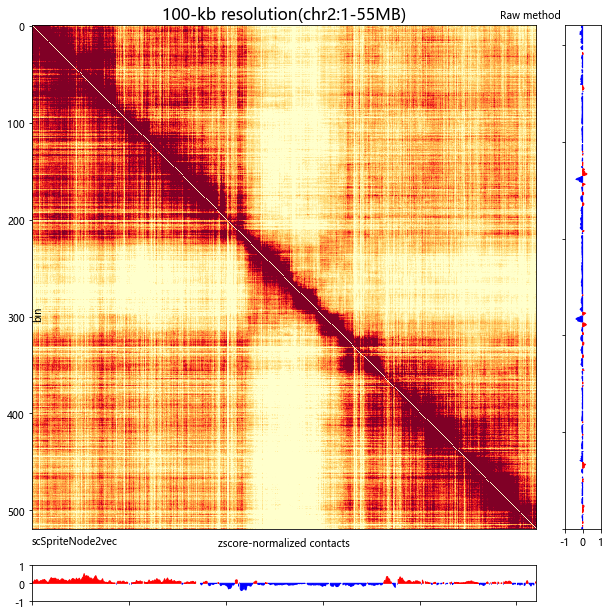

In [190]:
ex2_e(r, n)